In [ ]:
# Requirements
!pip install tensorflow_datasets flax jax optax tqdm netket imgaug==0.2.6

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp
import jax
import flax
import netket as nk
import jax.numpy as jnp
from jax.experimental import stax
import optax
from flax.training import train_state  # Useful dataclass to keep train state
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

### Utility Functions

In [ ]:
def show_img(img, ax=None, title=None):
  """Shows a single image.
  
  Must be stored as a 3d-tensor where the last dimension is 1 channel (greyscale)
  """
  if ax is None:
    ax = plt.gca()
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

## Setting up the dataset

In [ ]:
#import
ds_builder = tfds.builder('cifar10')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

#delete the id 
del train_ds['id']
del test_ds['id']


# Normalize
train_ds['image'] = jnp.float32(train_ds['image']) / 255.
test_ds['image'] = jnp.float32(test_ds['image']) / 255.
print("dataset keys:", train_ds.keys())
print(f"The training dataset has shape: {train_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print(f"The test     dataset has shape: {test_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print("")
print(f"The training labels have shape: {train_ds['label'].shape} and dtype {train_ds['label'].dtype}")
print(f"The test     labels have shape: {test_ds['label'].shape} and dtype {test_ds['label'].dtype}")
print("The mean     of the data stored in the images are: ", np.mean(train_ds['image']))
print("The variance of the data stored in the images are: ", np.var(train_ds['image']))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteDUSISL/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteDUSISL/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


dataset keys: dict_keys(['image', 'label'])
The training dataset has shape: (50000, 32, 32, 3) and dtype float32
The test     dataset has shape: (10000, 32, 32, 3) and dtype float32

The training labels have shape: (50000,) and dtype int64
The test     labels have shape: (10000,) and dtype int64
The mean     of the data stored in the images are:  0.47336298
The variance of the data stored in the images are:  0.063286915


## Define Model

In [ ]:
class Model(nk.nn.Module):
  n_classes : int = 10
  @nk.nn.compact
  def __call__(self, x, train):
    #make rng for dropout
    dropout_rng = self.make_rng('dropout')

    #first TWO convolutions 3x3 --> 32. Avgpol 2x2 stride 2x2. Dropout 0.2
    x = nk.nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nk.nn.relu(x)
    x = nk.nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nk.nn.relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = flax.linen.Dropout(0.2, deterministic=not train)(x)

    #second TWO convolutions 64x64 --> 32. Avgpol 2x2 stride 2x2. Dropout 0.2
    x = nk.nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nk.nn.relu(x)
    x = nk.nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nk.nn.relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = flax.linen.Dropout(0.2, deterministic=not train)(x)

    #third TWO convolutions 128x128 --> 32. Avgpol 2x2 stride 2x2. Dropout 0.2
    x = nk.nn.Conv(features=128, kernel_size=(3, 3))(x)
    x = nk.nn.relu(x)
    x = nk.nn.Conv(features=128, kernel_size=(3, 3))(x)
    x = nk.nn.relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = flax.linen.Dropout(0.2, deterministic=not train)(x)


    #flatten and dense 1
    x = x.reshape((x.shape[0], -1)) # Flatten
    x = nk.nn.Dense(features=128)(x)
    x = nk.nn.relu(x)

    #DROPOUT2
    #x = flax.linen.Dropout(0.5, deterministic=not train)(x) 

    #dense2 and softmax
    x = nk.nn.Dense(features=10)(x)
    x = nk.nn.log_softmax(x)
    return x


## Loss functions

In [ ]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [ ]:
dropout_rng, init_dropout = jax.random.split(jax.random.PRNGKey(1))


In [ ]:
def loss_fn(params, dropout_rng, images, labels):
    """
    Loss function minimised during training of the model.
    """
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    return cross_entropy(logits=logits, labels=labels)

def compute_metrics(*, logits, labels):
    """
    Compute metrics of the model during training.
    
    Returns the loss and the accuracy.
    """
    loss = cross_entropy(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

## 4 - functions for adversarial attack

In [ ]:
@jax.jit
def eval_metrics(params, batch, dropout_rng):
    """
    This function evaluates the metrics without training the model.
    
    Used to check the performance of the network on training and test datasets.
    """
    logits = model.apply(params, batch['image'], rngs={'dropout' : dropout_rng}, train=False)
    return compute_metrics(logits=logits, labels=batch['label'])

In [ ]:
def fgsm_update(image, data_grad, update_max_norm):
    """
    Compute the FGSM update on an image (or a batch of images)

    @param image: float32 tensor of shape (batch_size, rgb, height, width)
    @param data_grad: float32 tensor of the same shape as `image`. Gradient of the loss with respect to `image`.
    @param update_max_norm: float, the maximum permitted difference between `image` and the output of this function measured in L_inf norm.

    @returns a perturbed version of `image` with the same shape
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = jnp.sign(data_grad)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + update_max_norm*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = jnp.clip(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def loss_fn2(images, params, dropout_rng, labels):
    """
    Loss function minimised during training of the model.
    """
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    return cross_entropy(logits=logits, labels=labels)


## 6 Import parameters and carry out attack

In [ ]:
import pickle

In [ ]:
#import parameters
with open("cifar_real_robust.txt", "rb") as fp:   
  parameters = pickle.load(fp)
len(parameters)

5

In [ ]:
def loss_fn2(images, params, dropout_rng, labels):
    """
    Loss function minimised during training of the model.
    """
    # compute the output of the model, which gives the 
    # log-probability distribution over the possible classes (0...9)
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    # feed it to the cross_entropy
    return cross_entropy(logits=logits, labels=labels)


In [ ]:
#copmuting the accuracy on 1.000/ 10.000 examples
def fgsm_full_data(eps, parameters):
  accuracy = 0
  for i in range(100):
    batch = test_ds['image'][100*i : 100 * (i+1)]
    _loss_fn2 = partial(loss_fn2, params=parameters, dropout_rng = dropout_rng, labels=test_ds['label'][100*i : 100 * (i+1)])
    grad = jax.grad(_loss_fn2)
    g = grad(batch)
    batch = fgsm_update(batch, g, eps)
    logits_with_fgsm = model.apply(parameters, batch, rngs={'dropout' : dropout_rng}, train=False)
    metrics = compute_metrics(logits=logits_with_fgsm, labels=test_ds['label'][100*i : 100 * (i+1)])
    accuracy += metrics['accuracy']
  accuracy = accuracy / 100.
  return accuracy

for_plot = []
for i in range(5):
  temp = []
  model = Model(n_classes=10)
  accuracies_attack = []
  noise_amplitude = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  noise_amplitude = [r*8./255 for r in noise_amplitude]
  for eps in noise_amplitude:
    print('eps =', eps)
    acc = fgsm_full_data(eps, parameters[i])
    print('acc = ', acc)
    temp += [acc]
  for_plot += [temp]

eps = 0.0031372549019607846
acc =  6.795999999999999
eps = 0.006274509803921569
acc =  6.505000000000001
eps = 0.009411764705882352
acc =  6.194000000000001
eps = 0.012549019607843138
acc =  5.884
eps = 0.01568627450980392
acc =  5.563
eps = 0.018823529411764704
acc =  5.263999999999999
eps = 0.021960784313725487
acc =  4.977999999999999
eps = 0.025098039215686277
acc =  4.667999999999999
eps = 0.02823529411764706
acc =  4.391
eps = 0.03137254901960784
acc =  4.142000000000001
eps = 0.0031372549019607846
acc =  6.768999999999997
eps = 0.006274509803921569
acc =  6.4879999999999995
eps = 0.009411764705882352
acc =  6.176
eps = 0.012549019607843138
acc =  5.904
eps = 0.01568627450980392
acc =  5.591999999999999
eps = 0.018823529411764704
acc =  5.319000000000002
eps = 0.021960784313725487
acc =  5.022000000000002
eps = 0.025098039215686277
acc =  4.741999999999998
eps = 0.02823529411764706
acc =  4.455999999999999
eps = 0.03137254901960784
acc =  4.195000000000002
eps = 0.003137254901960

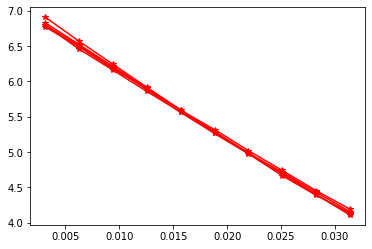

In [ ]:
for i in range(5):
  plt.plot(noise_amplitude, for_plot[i] , "*-",  c = 'r')

In [ ]:
#dump the data for the plot
with open("cifar_real_robust_fp.txt", "wb") as fp:   #Pickling
  pickle.dump(for_plot, fp)

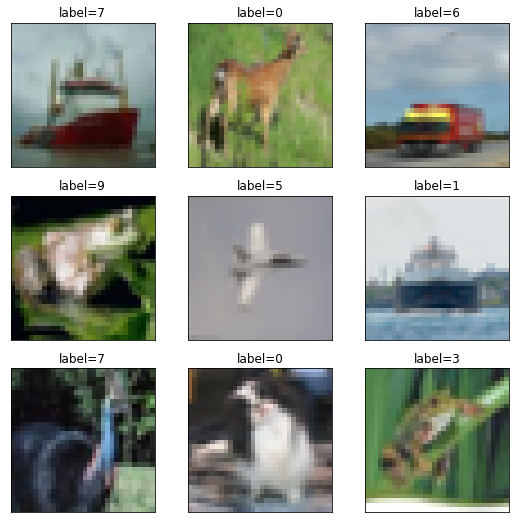

In [ ]:
#show (most) perturbed pictures
batch_original = test_ds['image'][100*i : 100 * (i+1)]
_loss_fn2 = partial(loss_fn2, params=parameters[0], dropout_rng = dropout_rng, labels=test_ds['label'][100*i : 100 * (i+1)])
grad = jax.grad(_loss_fn2)
g = grad(batch_original)
batch_perturbed = fgsm_update(batch_original, g, 0.1)

show_img_grid(
    [batch_original[idx] for idx in range(9)],
    [f'label={test_ds["label"][idx]}' for idx in range(9)],
)

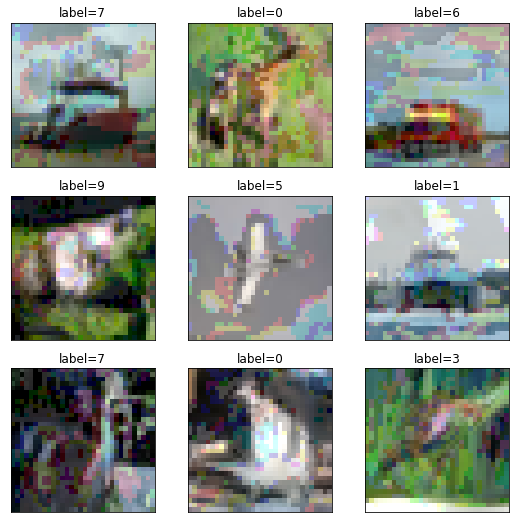

In [ ]:
#show the most perturbed pictures
show_img_grid(
    [batch_perturbed[idx] for idx in range(9)],
    [f'label={test_ds["label"][idx]}' for idx in range(9)],
)